# Boundary value problem: one-dimensional Schrodinger equation


## 2021 Spring "EE479: Scientific Computing & Data"
### Tae Hyung Kim, KAIST Electrical Engineering
### Koonin & Meredith, Computational Physics, Ch. 3
### 2021.04.09 Reivsed from Example 3 code



The Schrodinger equation can be written as
$$
-\frac{{\hbar}^2}{2m} \frac{d\psi({X})}{d {X}^2} + (V({X})-{E}))\psi({X}) \tag{1} = 0
$$  

Then, eq.(1) can be rewritten by dimensionless unit as below 
$$
-\frac{{1}}{\gamma^2} \frac{d\psi({x})}{d {x}^2} + (v({x})-{\epsilon}))\psi({x}) \tag{2} = 0
$$  

where ${\gamma^2}=(\frac{2ma^2V_{0}}{\hbar^2})^\frac{1}{2}$ is a dimensionless measure of the classical nature of the system and $\epsilon = E/V_{0}$ is the dimensionless energy.

### ODE solver, root finding, intergral modules 
(ODE: ordinary differential equation)

Intergral: Simpson <br>
Root finding: Secant, Bisection <br>
ODE solver: Numerov, Euler-Cromer  

In [154]:
import sys
import numpy as np

# 2nd ODE solver, refer to Koonin Ch.3
def numerov(ngrid, h, y_0, y_1, k, S=[]): 
    if S == []:
        S = np.zeros(ngrid) # default S is 0
   
    if ngrid == 1:
        y = np.array([y_0])
        return y
    
    # initialize y
    y = np.zeros(ngrid)
    y[0] = y_0
    y[1] = y_1

    # main loop: evaluate y[j]
    for j in np.arange(2, ngrid):

        y1 = y[j-2]; y2 = y[j-1]
        k1 = k[j-2]; k2 = k[j-1]; k3 = k[j]
        s1 = S[j-2]; s2 = S[j-1]; s3 = S[j] 

        term_S = 1/12. * h**2 * (s3 + 10*s2 + s1)
        term_3 =      (1 + 1/12. *   h**2 * k3)
        term_2 = -2 * (1 - 5/12. *   h**2 * k2) * y2
        term_1 =      (1 + 1/12. *   h**2 * k1) * y1

        y3 = (term_S - term_2 - term_1) / term_3
        y[j] = y3

    return y

#2nd ODE solver, EulerCromer from L&L
def EulerCromer(x, K, U_0, V_0, dx):
    from numpy import zeros, linspace
    lenx=len(x)
    u = zeros(lenx)
    v = zeros(lenx)

    # Initial condition
    u[0] = U_0
    v[0] = V_0
    
    # Step equations forward in time
    for n in range(lenx-1):
        v[n+1] = v[n] + dx*K[n]*u[n]
        u[n+1] = u[n] + dx*v[n+1]

    return u

# Newton method from L&L.
# Root finding using dfdx information. 
# The procedure stops when the function value has absolute value <=eps
# or number of iterations (number of midpoints calculated) == maxIter.
def Newton(f, dfdx, x, maxiter, eps):
    f_value = f(x)
    iteration_counter = 0
    while abs(f_value) > eps and iteration_counter < maxiter:
        try:
            x = x -float(f_value)/dfdx(x)
        except ZeroDivisionError:
            print("Error! - derivative zero for x = ", x)
            sys.exit(1)  # Abort with error / Sys.exit(0) means succesfully operating
            
        f_value = f(x)
        iteration_counter += 1
        
    # Here, either a solution is found, or too many iterations
    if abs(f_value) > eps:
        iteration_counter = -1
    return x, iteration_counter

# Secant method from L&L.
# Root finding using inclination information. 
# The procedure stops when the function value has absolute value <=eps
# or number of iterations (number of midpoints calculated) == maxIter.
def secant(f, x0, x1, maxiter, eps):
    f_x0 = f(x0)
    f_x1 = f(x1)
    iteration_counter = 0
    while abs(f_x1) > eps and iteration_counter < maxiter:
        try:
            denominator = float(f_x1 - f_x0)/(x1 - x0)
            x = x1 - float(f_x1) / denominator
            print('%d % 20.10f, % 20.10f' % (iteration_counter+1, x, f(x)))
        except ZeroDivisionError:
            print("Error! - denominator zero for x = ", x)
            sys.exit(1)  # Abort with error
        x0 = x1
        x1 = x
        f_x0 = f_x1
        f_x1 = f(x1)
        iteration_counter += 1
    # Here, either a solution is found, or too many iterations
    if abs(f_x1) > eps:
        iteration_counter = -1
    return x, iteration_counter

# bisection method from L&L
# For the funcfion F with left and right endpoints X_l and X_r resp., 
# This function implements the bisection method.
# The procedure stops (with SUCCESS flag true) when the function value has absolute value <=eps
# or number of iterations (number of midpoints calculated) == maxIter.
def bisection(f, x_L, x_R, maxIter=50, eps=1E-2):
    success = False
    f_L = f(x_L)
    f_R = f(x_R)
    if f_L*f_R > 0:
        print("Error! Function does not have opposite \
                signs at interval endpoints")
        sys.exit(1)
    x_M = (x_L + x_R)/2
    f_M = f(x_M)
    iteration_counter = 1

    while abs(f_M) > eps and iteration_counter < maxIter:
        if f_L*f_M > 0: # i.e. same sign
            x_L = x_M
            f_L = f_M
        else:
            x_R = x_M
        x_M = float(x_L + x_R)/2.0
        f_M = f(x_M)
        iteration_counter += 1
        #print("bisection: iteration counter = %i " %iteration_counter)
        #print(f"bisection: iteration {iteration_counter}, f_M: {x_M:10.5f} {f_M:1.12f} ")
    if abs(f_M) <= eps:
        success = True
    
    return x_M, success

# Performs numerical quadrature using Simpson's rule.
# The function values are given in FVALUES.
# H containes the distance between the grid points.
def simpson(fvalues, h):
    length = len(fvalues)
    if length < 2:
        return 0
    if length == 2:
        return sum(fvalues)*h/2
    
    if length % 2 == 1:
        return simpson_odd(fvalues,h)
    else:
        return simpson_odd(fvalues[:-1],h) + (fvalues[-1]+fvalues[-2])*h/2
    
# simpson_odd implements Simpson's quadrature whenver len(fvalues) is odd >= 3.
def simpson_odd(fvalues, h):
    length = len(fvalues)
    if length < 3:
        print('simpson_odd(): Improper size of the argument fvalues')
        sys.exit(1)
    if length % 2 == 0:
        print("simpson_odd(): Composite Simpson's rule works for FVALUES with odd length.")
        sys.exit(1)
    k = round((length+1)/2)
    result = 0
    for i in range(k):
        result += 2*fvalues[2*i]
    for i in range(k-1):
        result += 4*fvalues[1+2*i]
    result -= fvalues[0]
    result -= fvalues[-1]
    
    result *= h/3
    return result



### Potentials: Square, Prabolic, Lennard-Jones, Delta, Double-well

In [155]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
#from mymodule import *

# Time-independent Schrodinger equation is \psi'' +k^2 \psi = 0
# with \psi(x_min)=\psi(x_max) = 0 ("infinite potential walls")
# where k^2 (x) := \frac{2m}{\hbar ^2} [E-V(x)] and V(x)=V_0 v(x)
# By change of x-coordinates as \bar{x} := x/a for some a>0,
# and denoting \bar{x} as x, we get the following equation.
# [-1/{\gamma^2} D^2 + v(x) - \epsilon] \psi(x) = 0
# where \gamma := (\frac{2ma^2 V_0}{\hbar^2})^(1/2) and \epsilon:=E/V_0

# The following three functions return three pre-defined potentials
# on X in [xmin,xmax], where NPTS equally spaces samples are used for X values.
# V is the returned potential values
def square(npts):
    well_height = 1                #v has a minimum values of -1 and maximum values of +1
    xmin = -2; xmax = 2
    x = np.linspace(xmin,xmax,npts)
    v = np.zeros(len(x))
    v = v - well_height
    print (v)
    return x, v

def parabolic(npts):
    xmin = -2; xmax = 2
    x = np.linspace(xmin,xmax,npts)
    v = 0.5 * x**2 - 1
    return x, v

def Lennard_Jones(npts):
    xmin = 0.7; xmax = 3
    x = np.linspace(xmin,xmax,npts)
    v = 1/(x**12) - 1/(x**6)
    v = 4 * v
    return x, v

def delta(npts):
    xmin = -5; xmax = 5
    x = np.linspace(xmin,xmax,npts)
    lorentz_const = 0.002 # approximate delta function by a Lorentzian function
    v = (lorentz_const/(2*np.pi)) / (x**2 + (lorentz_const/2)**2)
    v = -v
    return x, v

# Double potential well : 
# This is a square potential well with bump at 
# the middle fifth subinterval of [xmin,xmax]
# where the bump has potential value v(x)=0
def doublewell(npts):
    xmin = -2; xmax = 2
    x = np.linspace(xmin,xmax,npts)
    v = np.zeros(len(x))
    v = v - 1
    j = round((npts-1)/5)
    v[2*j:3*j+1] = 0
    v[2*j] = -0.5 # smoothing at the bump edge
    v[3*j] = -0.5 
    return x, v



### Shooting method: bisection + secant
Find the root coarsely using bisection method, then change algorithm to secant for finding the exact root

In [156]:
def search(npts, h, v, E, gamma, print_denominators=False):
    ''' Implements the shooting method.
    Here, v is the potential term. gamma represents a constant with some
    physical meaning. E is the trial eigenvalue. npts is the number of grid points.
    h is the distance between the grid points.
    First, this function searches for the leftmost solution
    of v(x)=E. The corresponding index is stored in the variable j.
    Then, it shoots from the left and shoots from the right, using the Numerov
    method. Then it normalizes the solution from the right, to match
    the function values at index j. The matched solution and the value of f is
    returned.'''

    turning_point_found = False
    for j in range(npts-1):
        if (v[j]-E)*(v[j+1]-E) < -1E-13: # when the potential == E
            turning_point_found = True
            break
    if (not turning_point_found) or (j == 0):
        j = round(npts/(np.e-0.1*np.pi)) # some index between 0 and npts-1
    
    numerov_k = -gamma**2 * (v-E) # k^2 values for the Numerov algorithm
    
    numerov_1 = numerov(j+1, h, 0, 1E-9, numerov_k[:j+1])   
    k_flipped = np.flip(numerov_k[j-1:])
    numerov_2 = numerov(npts-j+1, h, 0, 1E-9, k_flipped)    
    numerov_2 = np.flip(numerov_2)                          # Calculation by outward and inward Numerov methods
    
    #if print_denominators:
    #    print('Prints the values of the denominators')
    #    print(numerov_2[1])
    #    print(numerov_1[-1])
    
    normalization_const = (numerov_1[-1]/numerov_2[1])    
    
    f = (numerov_1[-2] - numerov_2[0]*normalization_const) / numerov_1[-1]
    numerov_2 *= normalization_const
    sol = np.hstack((numerov_1,numerov_2[2:]))
    return f, sol


# This function calculates the approximate solution, but only uses forward 
# integration. That is, it "shoots" the solution from the left endpoint
# and checks if the boundary condition at the right endpoint is matched.
# The value of the approximate solution at the right endpoint is stored in
# the variable F.

    
def simulation(gamma, E, dE, dE_for_secant, potential, steps, maxstp=100, tol = 1E-6, npts = 1501):
    '''This function first evaluates the f values for
    E, E+dE, ..., E+30*dE and finds out where the sign changes for the first
    time, say, between E+i*dE and E+(i+1)*dE.
    Then, it performs bisection method on [E+i*dE, E+(i+1)*dE] and the result
    is used as the new E value.
    Then, it performs secant method to find a root of f,
    where E and E+dE_for_secant are used as two initial points for the method.
    If everything was successful, eigenvalue_found is set to True,
    and (eigenvalue, grid points(x), psi(eigenfunction), eigenvalue_found flag) is returned.
     '''
    
    eigenvalue_found = False
    if npts < 20:
        print('Please give larger value for NPTS to get accurate results')
        sys.exit(1)
    if potential == 'square':
        (x, v) = square(npts)
    elif potential == 'parabolic':
        (x, v) = parabolic(npts)
    elif potential == 'Lennard_Jones':
        (x, v) = Lennard_Jones(npts)
    elif potential == 'delta':
        (x, v) = delta(npts)
    elif potential == 'doublewell':
        (x, v) = doublewell(npts)
    else:
        print('Invalid potential')
        sys.exit(1)
        
    h = (x[-1]-x[0])/(npts-1)
    f = np.zeros(maxstp+2)    
    
    def f_value(energy):
        (result,_) = search(npts, h, v, energy, gamma)
        
        return result
    
    sign_change_flag = False
    sign = np.sign(f_value(E))
    # First, search for sign change.
    for i in range(30):
        if sign * np.sign(f_value(E+(i+1)*dE)) <= 0:
            sign_change_flag = True
            break    
    if not sign_change_flag: # No sign change ocurred upto E+30*dE
        return 0, [], [], eigenvalue_found
   
    # Use bisection method to narrow the search for eigenvalues
    E += i*dE
    (E, bisection_success_flag) = bisection(f_value, E, E+dE)
    if not bisection_success_flag:
        # The function search() may divide by zero,
        # which leads to discontinuities of f at some values of E.
        # Therefore, the preliminary search using the bisection method may fail
        return 0, [], [], eigenvalue_found
    
    # Performs secant method for better accuracy
    # Initial points are E, E+dE_for_secant
    f[0] = f_value(E)
    f[1] = f_value(E+dE_for_secant)
    
    prev_E = E
    E = E+dE_for_secant
    counter = 0
    for i in range(maxstp):
        
        new_E = E - f[i+1]*(E-prev_E)/(f[i+1]-f[i])
        prev_E = E
        E = new_E
        (f[i+2],sol) = search(npts, h, v, E, gamma)
        counter += 1
        print("secant:_iter = %i" %counter)
        if (abs(f[i+2]) < tol):
            eigenvalue_found = True
            # plt.plot(x, sol)
            # print(E)
            break
    
    #plot figures
    if steps == 0:
        fig = plt.figure(figsize=(9,4))
        plt.xlabel('x-axis')
        plt.ylabel('Potential')
        plt.plot(x,v,'g')
        plt.show()
        
    return E, x, sol, eigenvalue_found
          


### Excute code

Doing simulation...
[-1. -1. -1. ... -1. -1. -1.]
secant:_iter = 1
secant:_iter = 2


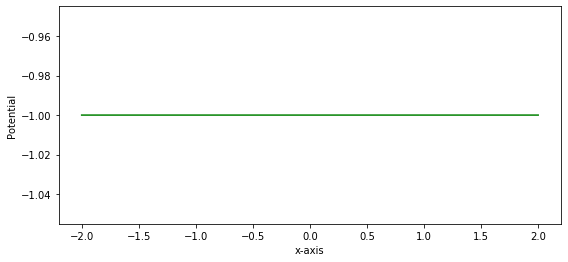

wavefunction number = 1
[-1. -1. -1. ... -1. -1. -1.]
secant:_iter = 1
secant:_iter = 2
wavefunction number = 2
[-1. -1. -1. ... -1. -1. -1.]
secant:_iter = 1
secant:_iter = 2
wavefunction number = 3
[-1. -1. -1. ... -1. -1. -1.]
bisection: iteration 2, f_M:   -0.99715 0.133369743573 
bisection: iteration 3, f_M:   -0.99709 -0.463798934453 
bisection: iteration 4, f_M:   -0.99712 0.387311387720 
bisection: iteration 5, f_M:   -0.99711 5.170221057533 
bisection: iteration 6, f_M:   -0.99710 -1.014313022921 
bisection: iteration 7, f_M:   -0.99710 -2.516275523005 
bisection: iteration 8, f_M:   -0.99711 -9.775382676762 
bisection: iteration 9, f_M:   -0.99711 21.986059219173 
bisection: iteration 10, f_M:   -0.99711 -35.179086380985 
bisection: iteration 11, f_M:   -0.99711 117.315930087054 
bisection: iteration 12, f_M:   -0.99711 -100.480613287143 
bisection: iteration 13, f_M:   -0.99711 -1399.805350817827 
bisection: iteration 14, f_M:   -0.99711 256.099798272245 
bisection: iteratio

bisection: iteration 38, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 39, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 40, f_M:   -0.99430 -2746957586.722500801086 
bisection: iteration 41, f_M:   -0.99430 -2746957586.722500801086 
bisection: iteration 42, f_M:   -0.99430 -2746957586.722500801086 
bisection: iteration 43, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 44, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 45, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 46, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 47, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 48, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 49, f_M:   -0.99430 3056991078.698740005493 
bisection: iteration 50, f_M:   -0.99430 3056991078.698740005493 
[-1. -1. -1. ... -1. -1. -1.]
bisection: iteration 2, f_M:   -0.99418 -0.136763281272 
bisection: iteration 3, f_M:   -0.99424 -0.305636364

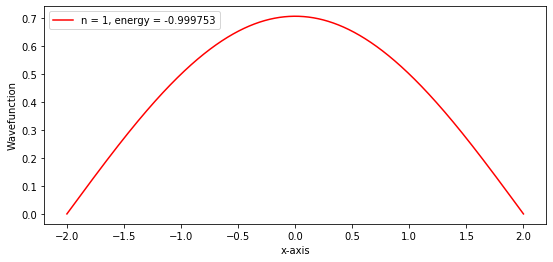

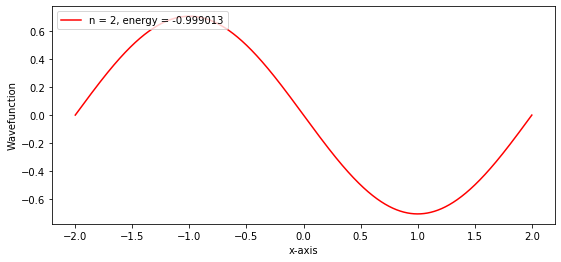

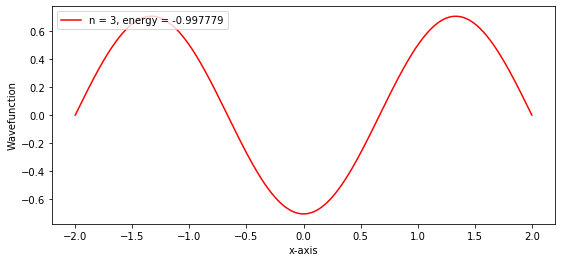

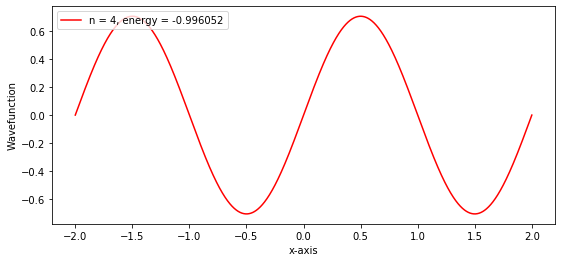

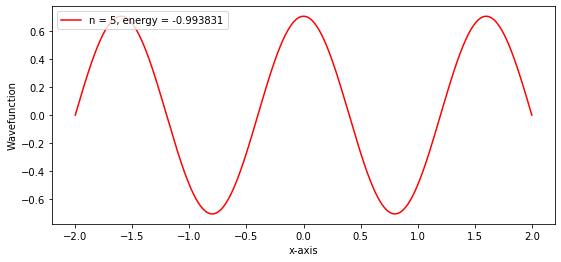

Time elapsed:
3.1412737369537354
Eigenvalues:
[-0.99975324 -0.99901304 -0.99777932 -0.99605216 -0.9938315 ]
Relative errors:
[0.01409471 0.04327547 0.07370147 0.10549009 0.13877373]


In [157]:
###################3# PARAMETERS #############################
no_of_eigen = 5     # number of eigenvalues you want to find
N = 1501            # number of mesh points

### please refer to the xmin, xmax values defined in
### the potential functions square(), parab(), lenrd(), delta(), and doublewell()
xmin = -2             # xmin for the potential you want to use
xmax = 2              # xmax for the potential you want to use
h = (xmax-xmin)/(N-1) # length between mesh points           
E = -1                # initial energy(that is, eigenvalue)
psi = np.zeros((no_of_eigen,N)) # Eigenfunctions found will be stored here
eig = np.zeros(no_of_eigen)     # Eigenvalues found will be stored here

## Two important parameters used for function simulation()
## YOU MUST CHANGE THESE PARAMETERS WHEN YOU WANT TO CHANGE GAMMA OR THE POTENTIAL ##
dE = 0.0005
dE_for_secant = dE/10
gamma = 50 # gamma, which is a parameter in the scaled Schrodinger's equation
well = 'square'


# The code below may be dangerous, but it tries to find out
# the first NO_OF_EIGEN eigenvalues of the problem.
t = time.time()
print ('Doing simulation...')
############################################# Start code ###############################################
steps = 0
for i in range(no_of_eigen):
    while True:
        (E_,x, sol, eigenvalue_found) = simulation(gamma, E, dE, dE_for_secant, well, steps, npts = N)
        if eigenvalue_found:
            psi[i,:] = sol
            eig[i] = E_
            E = E_ + dE # If an eigenvalue E_ was found, then start searching again from E_+dE
            break
        E += dE
    print ('wavefunction number = %i' %(steps+1))
    steps += 1
#######################################################################################################
elapsed = time.time() - t # Measures elapsed time in seconds


for i in range(no_of_eigen):
    L2norm = np.sqrt(simpson(abs(psi[i,:])**2,h))
    psi[i,:] /= L2norm  # L2 normalization
for i in range(no_of_eigen):
    fig = plt.figure(figsize=(9,4))
    plt.xlabel('x-axis')
    plt.ylabel('Wavefunction')
    plt.plot(x, psi[i,:], color = 'r', label = "n = %i, energy = %f" %(i+1, eig[i])) # plots the eigenfunctions
    plt.legend(loc=2)
plt.show()

z = np.zeros(no_of_eigen)
for i in range(no_of_eigen):
    #z[i] = ((i+1)*np.pi / (4*gamma)) ** 2-1     #analytic sol @ square potential
    z[i] = (i+0.5)*np.sqrt(2)/gamma -1         #analytic sol @ parabolic potential
error = abs(z-eig)/abs(z)

print('Time elapsed:')
print(elapsed)
print('Eigenvalues:')     
print(eig)
print('Relative errors:')
print(error)